In [1]:
import os
import cv2
import glob
import time
import pickle
import random
import numpy as np
from skimage.feature import hog
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.ndimage.measurements import label
%matplotlib inline

In [3]:
from libraries.utils import *
from libraries.libraryObjectDetectionImproved import *
from libraries.detector import Detector

In [3]:
data=load_p("./data.pickle")

X=data["X"]
Y=data["Y"]
clf=data["clf"]
scaler=data["scaler"]

In [4]:
def find_subimages_boxes_features(img, scale, ystart = 400, ystop = 656, window=64, pix_per_cell=16, cell_per_block=2, orient=11, 
                       cells_per_step = 2):
    
    #img = img.astype(np.float32)/255
    
    img_processed = img[ystart:ystop,:,:]
    img_processed = color_space(img_processed, "yuv")
    if scale != 1:
        n, m, k = img_processed.shape
        img_processed = cv2.resize(img_processed, (np.int(m/scale), np.int(n/scale)))
        
    ch1 = img_processed[:,:,0]
    ch2 = img_processed[:,:,1]
    ch3 = img_processed[:,:,2]
    
    nc, mc = ch1.shape
    # Define blocks and steps as above
    n_blocks_x = (mc // pix_per_cell) - cell_per_block + 1
    n_blocks_y = (nc // pix_per_cell) - cell_per_block + 1 
    n_feat_block = orient*cell_per_block**2
    
    n_blocks_window = (window // pix_per_cell) - cell_per_block + 1
    n_steps_x = (n_blocks_x - n_blocks_window) // cells_per_step
    n_steps_y = (n_blocks_y - n_blocks_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = f_hog(ch1)
    hog2 = f_hog(ch2)
    hog3 = f_hog(ch3)
    
    list_boxes=[]
    #list_subimages=[]
    list_features=[]
    
    for xb in range(n_steps_x):
        for yb in range(n_steps_y):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+n_blocks_window, xpos:xpos+n_blocks_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+n_blocks_window, xpos:xpos+n_blocks_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+n_blocks_window, xpos:xpos+n_blocks_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            subimg = cv2.resize(img_processed[ytop:ytop+window, xleft:xleft+window], (64,64))
            
            # convert
            xleft_box = np.int(xleft*scale)
            ytop_box = np.int(ytop*scale)
            win_box = np.int(window*scale)
            bottom_left=(xleft_box, ytop_box+win_box+ystart)
            upper_right=(xleft_box+win_box, ytop_box+ystart )
            
            list_features.append(hog_features)
            list_boxes.append((bottom_left, upper_right))
            ##list_subimages.append(subimg)
    
    features=np.array(list_features)
    features=scaler.transform(features)
            
    return features, list_boxes

In [5]:
def detection_image(img, scale, flag):
    features, list_boxes=find_subimages_boxes_features(img, scale=scale)
    
    prediction=clf.predict(features)
    index_detections=list(np.where(prediction==1)[0])
    
    detections=[list_boxes[ix] for ix in index_detections]
    
    if flag:
        for d in detections:
            bottom_left=d[0]
            upper_right=d[1]
            z=cv2.rectangle(img,bottom_left,upper_right,(0,0,255), 6)
    return detections

def detection_multiscale(img, scales, flag=False):
    detections=[]
    for s in scales:
        detection=detection_image(img, scale=s, flag=flag)
        detections.extend(detection)
    return detections

In [6]:
img=mpimg.imread("./test_images/test5.jpg")

In [7]:
detections=detection_multiscale(img, scales=[1.0,1.6], flag=True)

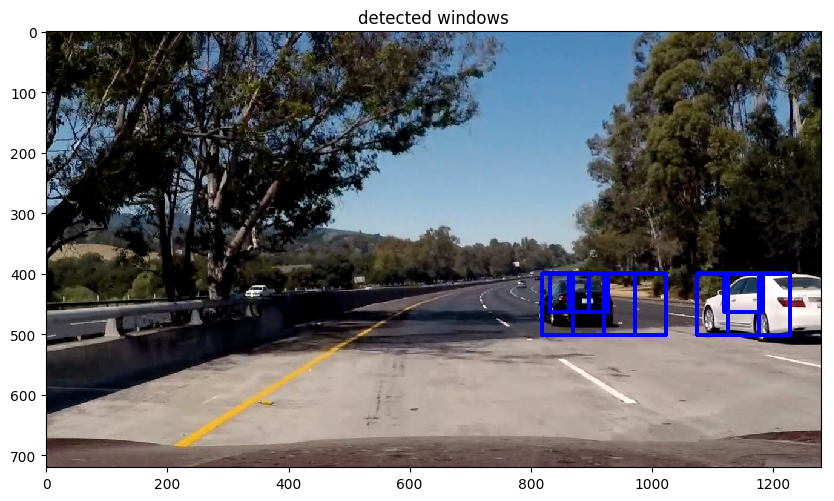

In [8]:
plot_image(img, "detected windows")

In [12]:
def pipeline(img, scales, t, flag=False):
    
    image=img.copy()
    detections=detection_multiscale(image, scales)
    heatmap=add_heat(image, detections,t)
    labels=compute_labels(heatmap)
    boxes=compute_boxes(labels)
    
    if flag:
        draw_img = draw_boxes(image, boxes)
        return draw_img, boxes
    
    return boxes

In [13]:
def plot_N_images(files, scales=[1.2, 1.4, 1.6, 1.8], t=0, flag=False):

    fig, axs = plt.subplots(len(files), 2, figsize=(20,20))
    fig.subplots_adjust(hspace = .2, wspace=.05)
    for f in range(len(files)):
        file = files[f]
        image = mpimg.imread("./test_images/" + file)
        img=image.copy()
        draw_img, boxes=pipeline(image, scales, t, flag=True)
        
        axs[f, 0].imshow(image)
        axs[f,1].imshow(draw_img)
        if flag:
            mpimg.imsave("output_images/" + file, draw_img, format="jpg")

In [14]:
files=os.listdir("./test_images/")
files

['test2.jpg', 'test5.jpg', 'test6.jpg', 'test1.jpg', 'test4.jpg', 'test3.jpg']

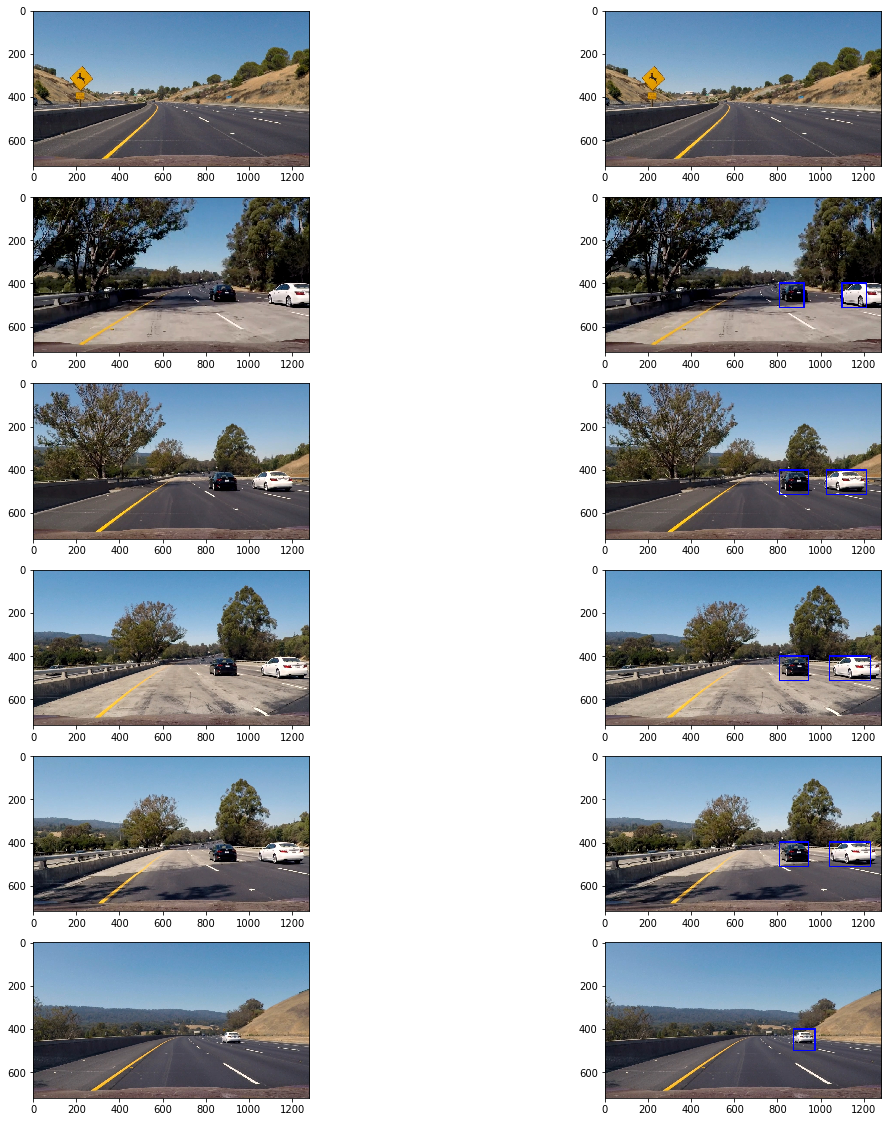

In [15]:
plot_N_images(files)
plt.savefig("pipeline.jpg")

In [154]:
detector=Detector()

def process_image(image):
    new_image = image.copy()
    boxes=pipeline(new_image, scales=[1.2, 1.4, 1.6, 1.8], t=1)
    
    detector.update(boxes)
    average_boxes=detector.get_boxes()
    
    res = draw_boxes(image, boxes)
    return res

In [155]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [149]:
video_output = 'test_video_output.mp4'
video_input = VideoFileClip('./test_video.mp4')
processed_video = video_input.fl_image(process_image)
%time processed_video.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4


 97%|█████████▋| 38/39 [01:05<00:01,  1.75s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output.mp4 

CPU times: user 1min 7s, sys: 184 ms, total: 1min 7s
Wall time: 1min 8s


In [150]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

In [156]:
video_output1 = './project_video_output.mp4'
video_input1 = VideoFileClip('./project_video.mp4')
processed_video = video_input1.fl_image(process_image)
%time processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video ./project_video_output.mp4
[MoviePy] Writing video ./project_video_output.mp4


100%|█████████▉| 1260/1261 [46:32<00:02,  2.11s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_output.mp4 

CPU times: user 47min 43s, sys: 5.46 s, total: 47min 48s
Wall time: 46min 35s


In [157]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output1))